In [1]:
import pandas as pd
import numpy as np
import subprocess
import random
import pipeline_script
import seaborn as sns
import math
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
from numpy.random import RandomState
from sklearn.preprocessing import MinMaxScaler

Import Processed Participant DF

In [2]:
participant_df = pd.read_csv("participant_info_processed.csv",index_col="SID")
participant_df["GENDER"]=participant_df["GENDER"].apply(lambda x: 1 if x == "M" else 0)
participant_df.head()

,AGE,GENDER,BMI,OAHI,AHI,Mean_SaO2,Arousal Index,MEDICAL_HISTORY,Sleep_Disorders,asthma,...,eds,rbd,hypersomnia,grind teeth,insomnia,fatigue,morning headaches,bruxism,snore,headache
SID,,,,,,,,,,,,,,,,,,,,,
S002,0.679909,1,0.166667,19,19,91%,98,"Asthma, Body Pain, GERD, Hypertension, Sleep A...",OSA,0,...,0,0,0,0,0,0,0,0,0,0
S003,0.124049,0,0.611111,34,37,95%,28,NaN,"snoring, sleep apnea, difficulty breathing, sn...",0,...,0,0,0,0,0,0,0,0,0,0
S004,0.524049,0,0.425926,63,99,89%,109,"Arrhythmia, Body Pain, Depression, Dyspnea, GERD",difficulty breathing,0,...,0,0,0,0,0,0,0,0,0,0
S005,0.424505,0,0.462963,19,20,95%,28,"Asthma, Body Pain, Depression, Diabetes, Dyspn...",OSA,0,...,0,0,0,0,0,0,0,0,0,0
S006,0.238661,0,0.074074,4,5,97%,34,"Depression, Sleep Apnea",OSA,0,...,0,0,0,0,0,0,0,0,0,0


Import Processed Patient Records

In [3]:
patient_records = pipeline_script.gather_dict("/Users/ufukcefaker/Desktop/bbm_folders/bbm469/normalized_data_3/")

100%|██████████| 98/98 [00:18<00:00,  5.20it/s]


Specify The Columns To Use In Training And Prediction

In [4]:
patient_records["S002"].head(1).columns

Index(['TIMESTAMP', 'BVP', 'ACC_X', 'ACC_Y', 'ACC_Z', 'TEMP', 'EDA', 'HR',
       'IBI', 'IBI_Moving_Average_640', 'IBI_Moving_STD_640', 'ACC',
       'HR_Divided_Mean', 'HR_Divided_Median',
       'Abnormal_IBI_Moving_4_Mean_Scaled', 'Sleep_Stage',
       'Abnormal_IBI_Moving_3', 'Abnormal_IBI_Moving_4'],
      dtype='object')

In [4]:
columns = [ 'BVP', 'ACC_X', 'ACC_Y', 'ACC_Z', 'TEMP', 'EDA', 'HR',
       'IBI',
       'Multiple_Events', 'IBI_Moving_Average_640', 'IBI_Moving_STD_640',
       'Abnormal_IBI_Moving_3', 'Abnormal_IBI_Moving_4', 'ACC',
       'HR_Divided_Mean', 'HR_Divided_Median',
       'Abnormal_IBI_Moving_4_Mean_Scaled']

In [6]:
participant_df.columns

Index(['AGE', 'GENDER', 'BMI', 'OAHI', 'AHI', 'Mean_SaO2', 'Arousal Index',
       'MEDICAL_HISTORY', 'Sleep_Disorders', 'asthma', 'body pain', 'gerd',
       'hypertension', 'sleep apnea', 'arrhythmia', 'depression', 'dyspnea',
       'diabetes', 'cad', 'anxiety', 'migraine', 'osa', 'snoring',
       'difficulty breathing', 'difficulty staying asleep', 'snort', 'rls',
       'eds', 'rbd', 'hypersomnia', 'grind teeth', 'insomnia', 'fatigue',
       'morning headaches', 'bruxism', 'snore', 'headache'],
      dtype='object')

In [5]:
columns_participant=['AGE', 'GENDER', 'BMI','asthma',
       'body pain', 'gerd', 'hypertension', 'sleep apnea', 'arrhythmia',
       'depression', 'dyspnea', 'diabetes', 'cad', 'anxiety', 'migraine',
       'osa', 'snoring', 'difficulty breathing', 'difficulty staying asleep',
       'snort', 'rls', 'eds', 'rbd', 'hypersomnia', 'grind teeth', 'insomnia',
       'fatigue', 'morning headaches', 'bruxism', 'snore', 'headache']

Dimensionality =

In [8]:
print(len(columns)+len(columns_participant))

48


In [9]:
for patient_id, patient_data in patient_records.items():
    # Count the occurrences of each Sleep_Stage
    counts = patient_data["Sleep_Stage"].value_counts()
    print(patient_id)
    print(counts)

S083
Sleep_Stage
W     64129
N2    45696
P     37670
N1    33024
R      5184
Name: count, dtype: int64
S029
Sleep_Stage
N2    89472
P     54682
W     48576
N1    16512
Name: count, dtype: int64
S084
Sleep_Stage
N2    66432
P     45677
R     37056
W     33984
N1    19968
Name: count, dtype: int64
S091
Sleep_Stage
N2    66048
P     51066
N3    30144
N1    24000
R     24000
W     13824
Name: count, dtype: int64
S096
Sleep_Stage
W     116353
P      45856
N2     27072
N3     11328
N1      4608
Name: count, dtype: int64
S069
Sleep_Stage
N2    77760
P     56154
W     32064
R     28608
N1    26112
N3      576
Name: count, dtype: int64
S058
Sleep_Stage
W     52992
N2    52224
P     49158
N1    47233
Name: count, dtype: int64
S018
Sleep_Stage
N2    95617
P     44576
R     32448
W     16512
N1    13056
Name: count, dtype: int64
S068
Sleep_Stage
N2    86400
P     38214
R     31297
N1    23040
W     19008
Name: count, dtype: int64
S097
Sleep_Stage
W     69505
N2    53376
P     41984
N3    16512
N1 

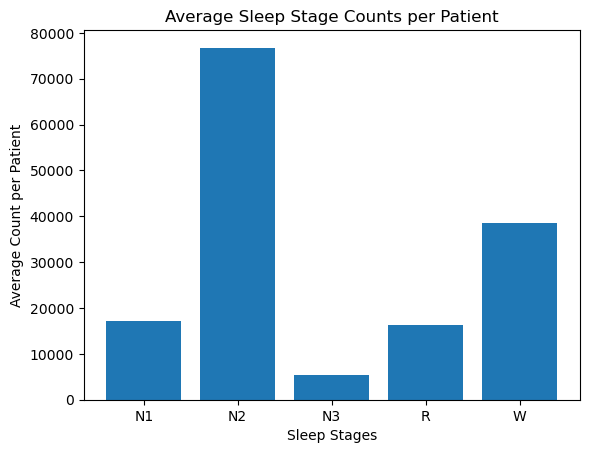

In [10]:
# Örnek total_counts
total_counts = {"N1": 0, "N2": 0, "N3": 0, "P": 0, "R": 0, "W": 0}

# Her bir dataframe'deki Sleep_Stage class'larını toplamak
for patient_id, df in patient_records.items():
    stage_counts = df['Sleep_Stage'].value_counts()
    for stage, count in stage_counts.items():
        if stage in total_counts:
            total_counts[stage] += count

# Hasta sayısı
patient_count = len(patient_records)

# Sınıf başına düşen ortalama
average_counts = {stage: count / patient_count for stage, count in total_counts.items()}
average_counts.pop("P")

# Visualize etme
plt.bar(average_counts.keys(), average_counts.values())
plt.xlabel('Sleep Stages')
plt.ylabel('Average Count per Patient')
plt.title('Average Sleep Stage Counts per Patient')
plt.show()


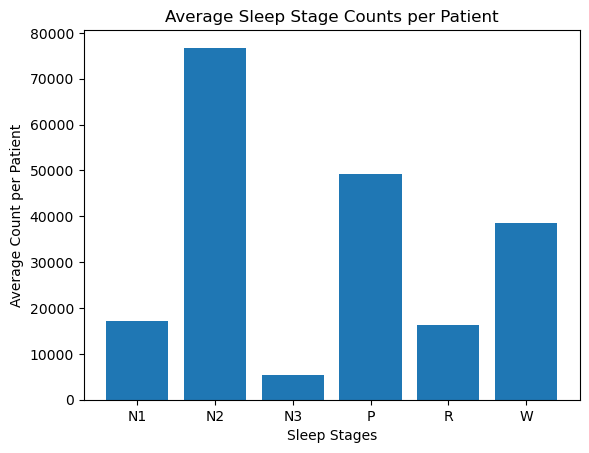

In [11]:
# Örnek total_counts
total_counts = {"N1": 0, "N2": 0, "N3": 0, "P": 0, "R": 0, "W": 0}

# Her bir dataframe'deki Sleep_Stage class'larını toplamak
for patient_id, df in patient_records.items():
    stage_counts = df['Sleep_Stage'].value_counts()
    for stage, count in stage_counts.items():
        if stage in total_counts:
            total_counts[stage] += count

# Hasta sayısı
patient_count = len(patient_records)

# Sınıf başına düşen ortalama
average_counts = {stage: count / patient_count for stage, count in total_counts.items()}


# Visualize etme
plt.bar(average_counts.keys(), average_counts.values())
plt.xlabel('Sleep Stages')
plt.ylabel('Average Count per Patient')
plt.title('Average Sleep Stage Counts per Patient')
plt.show()

In [12]:
# N2 değerlerini toplamak için bir liste
n2_counts = []

# Her bir hastanın N2 sayısını bul
for patient_id, df in patient_records.items():
    n2_count = df['Sleep_Stage'].value_counts().get("N2", 0)
    n2_counts.append((patient_id, n2_count))

# N2 değerine göre sıralama
n2_counts_sorted = sorted(n2_counts, key=lambda x: x[1])

# İlk 5 hastayı seçme
top_5_patients_with_min_n2 = n2_counts_sorted[:5]

# Sonuçları yazdırma
print("N2 değeri en az olan ilk 5 hasta:")
for patient_id, n2_count in top_5_patients_with_min_n2:
    print(f"Hasta ID: {patient_id}, N2 Sayısı: {n2_count}")

N2 değeri en az olan ilk 5 hasta:
Hasta ID: S082, N2 Sayısı: 15360
Hasta ID: S087, N2 Sayısı: 18432
Hasta ID: S096, N2 Sayısı: 27072
Hasta ID: S090, N2 Sayısı: 30720
Hasta ID: S072, N2 Sayısı: 30912


In [13]:
# N3 değeri 0 olan hastaların kimliklerini toplamak
patients_with_n3_zero = []

# Her bir hastanın N3 sayısını kontrol et
for patient_id, df in patient_records.items():
    n3_count = df['Sleep_Stage'].value_counts().get("N3", 0)
    if n3_count == 0:
        patients_with_n3_zero.append(patient_id)

# Sonuçları yazdır
print(f"N3 değeri 0 olan hastalar: {patients_with_n3_zero}")
n3_zero_count = len(patients_with_n3_zero)
print(f"N3 değeri 0 olan hasta sayısı: {n3_zero_count}")

N3 değeri 0 olan hastalar: ['S083', 'S029', 'S084', 'S058', 'S018', 'S068', 'S085', 'S082', 'S019', 'S053', 'S088', 'S022', 'S025', 'S070', 'S037', 'S062', 'S047', 'S012', 'S055', 'S063', 'S064', 'S071', 'S024', 'S089', 'S101', 'S010', 'S045', 'S017', 'S002', 'S057', 'S021', 'S074', 'S051', 'S056', 'S043', 'S016', 'S072', 'S067', 'S032', 'S038', 'S080', 'S078', 'S087', 'S049', 'S086', 'S079', 'S093', 'S039', 'S048']
N3 değeri 0 olan hasta sayısı: 49


In [14]:
# N2 değerlerini toplamak için bir liste
n2_counts = []

# Her bir hastanın N2 sayısını bul
for patient_id, df in patient_records.items():
    n2_count = df['Sleep_Stage'].value_counts().get("N2", 0)
    n2_counts.append((patient_id, n2_count))

# N2 değerine göre azalan sırayla sıralama
n2_counts_sorted = sorted(n2_counts, key=lambda x: x[1], reverse=True)

# N2 değeri maksimum olan 5 hastayı bul
top_5_n2_patients = n2_counts_sorted[:5]

# Sonuçları yazdır
print("N2 değeri maksimum olan 5 hasta ve değerleri:")
for patient_id, n2_count in top_5_n2_patients:
    print(f"Hasta ID: {patient_id}, N2 Sayısı: {n2_count}")


N2 değeri maksimum olan 5 hasta ve değerleri:
Hasta ID: S074, N2 Sayısı: 125761
Hasta ID: S100, N2 Sayısı: 116545
Hasta ID: S031, N2 Sayısı: 111168
Hasta ID: S050, N2 Sayısı: 110784
Hasta ID: S033, N2 Sayısı: 107137


Creating Model

1. Random Forest

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, KFold


In [7]:
train_set1 = {}
for i,v in tqdm(patient_records.items()):
    train_set1[i] = v.loc[v["Sleep_Stage"]!="P"]
    for column in columns_participant:
        train_set1[i].loc[:,column] = participant_df.loc[i,column]


  0%|          | 0/98 [00:00<?, ?it/s]/var/folders/j_/pyk9bhh561xgxgvl3mht666r0000gn/T/ipykernel_9046/1693293035.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set1[i].loc[:,column] = participant_df.loc[i,column]
/var/folders/j_/pyk9bhh561xgxgvl3mht666r0000gn/T/ipykernel_9046/1693293035.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set1[i].loc[:,column] = participant_df.loc[i,column]
/var/folders/j_/pyk9bhh561xgxgvl3mht666r0000gn/T/ipykernel_9046/1693293035.py:5: SettingWithCopyWarnin

In [8]:
train_set2 = patient_records
print(train_set2["S002"])

        TIMESTAMP       BVP     ACC_X     ACC_Y     ACC_Z      TEMP       EDA  \
0        0.000002  0.516264  0.619608  0.533333  0.716078  0.892820  0.001266   
1        0.000006  0.515512  0.612549  0.533333  0.712157  0.892820  0.001266   
2        0.000010  0.515111  0.595294  0.540392  0.725490  0.892820  0.001266   
3        0.000015  0.516043  0.560000  0.536471  0.709804  0.892820  0.001266   
4        0.000019  0.516259  0.613333  0.537255  0.732549  0.892820  0.001266   
...           ...       ...       ...       ...       ...       ...       ...   
201365   0.848343  0.507634  0.372549  0.407843  0.698039  0.884495  0.002443   
201366   0.848347  0.534856  0.372549  0.407843  0.698039  0.884495  0.002456   
201367   0.848352  0.525918  0.372549  0.407843  0.698039  0.884495  0.002465   
201368   0.848356  0.539900  0.372549  0.407843  0.698039  0.884495  0.002465   
201369   0.848359  0.530366  0.372549  0.407843  0.699160  0.884272  0.002469   

              HR       IBI 

In [10]:
rng = np.random.default_rng(seed = 30)
test_validation_indexes = rng.random(30)
a, b = 0, len(patient_records.keys())  # Example range
test_validation_indexes = np.floor(a + (b - a) * test_validation_indexes)
test_validation_indexes = [int(i) for i in test_validation_indexes]

validation_indexes = test_validation_indexes[:15]
test_indexes = test_validation_indexes[15:]
print(validation_indexes,test_indexes)

[23, 42, 9, 58, 76, 85, 31, 10, 39, 57, 24, 63, 88, 38, 46] [75, 59, 72, 49, 86, 15, 58, 9, 94, 42, 11, 88, 91, 23, 31]


In [11]:
for index in test_indexes:  # test_indexes içindeki indeksler
    key = f"S{index:03}"  # Sayıları 'SXXX' formatına dönüştür (örneğin 76 -> 'S076')
    
    if key in patient_records:  # Anahtar sözlükte var mı kontrol et
        print(f"Test - Index {key}:")
        df = patient_records[key]  # Sözlükten doğru anahtara göre veri al
        print(df["Sleep_Stage"].value_counts())  # Sleep_Stage sınıf dağılımını yazdır
    else:
        print(f"Key '{key}' not found in patient_records!")




Test - Index S075:
Sleep_Stage
N2    39841
P     29184
W     19392
R      6336
N1     4128
N3      192
Name: count, dtype: int64
Test - Index S059:
Sleep_Stage
N1    29088
W     23520
N2    23136
P     20964
R      2784
N3      288
Name: count, dtype: int64
Test - Index S072:
Sleep_Stage
W     42048
P     29847
N2    15456
N1    12864
Name: count, dtype: int64
Test - Index S049:
Sleep_Stage
N2    52416
P     30957
W     13536
R      8160
N1     2112
Name: count, dtype: int64
Test - Index S086:
Sleep_Stage
N2    37249
P     22608
W     22368
N1    12576
R      7680
Name: count, dtype: int64
Test - Index S015:
Sleep_Stage
N2    52512
P     27002
R     18240
N3     7200
N1     6912
W      6816
Name: count, dtype: int64
Test - Index S058:
Sleep_Stage
W     26496
N2    26112
P     24580
N1    23616
Name: count, dtype: int64
Test - Index S009:
Sleep_Stage
N2    39264
W     24192
P     20941
R      7296
N1     6432
N3      288
Name: count, dtype: int64
Test - Index S094:
Sleep_Stage
N2    512

from sklearn.model_selection import train_test_split
import pandas as pd

# Tüm hastaların Sleep_Stage evrelerini içeren bir liste oluştur
sleep_stage_data = []

for key, df in patient_records.items():
    stage_counts = df["Sleep_Stage"].value_counts().to_dict()
    sleep_stage_data.append({
        "patient": key,
        "N1": stage_counts.get("N1", 0),
        "N2": stage_counts.get("N2", 0),
        "N3": stage_counts.get("N3", 0),
        "P": stage_counts.get("P", 0),
        "W": stage_counts.get("W", 0),
        "R": stage_counts.get("R", 0)
    })

# Verileri birleştirerek DataFrame oluştur
sleep_stage_df = pd.DataFrame(sleep_stage_data)

In [12]:
a = patient_records["S002"]
train_set = {}


In [ ]:
for i,v in tqdm(patient_records.items()):
    train_set[i] = v.loc[v["Sleep_Stage"]!="P"]
    for column in columns_participant:
        train_set[i].loc[:,column] = participant_df.loc[i,column]


  0%|          | 0/98 [00:00<?, ?it/s]/var/folders/j_/pyk9bhh561xgxgvl3mht666r0000gn/T/ipykernel_31029/2420163684.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set[i].loc[:,column] = participant_df.loc[i,column]
/var/folders/j_/pyk9bhh561xgxgvl3mht666r0000gn/T/ipykernel_31029/2420163684.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set[i].loc[:,column] = participant_df.loc[i,column]
/var/folders/j_/pyk9bhh561xgxgvl3mht666r0000gn/T/ipykernel_31029/2420163684.py:4: SettingWithCopyWarni

In [18]:
train_set1["S002"]["GENDER"]

58714     1
58715     1
58716     1
58717     1
58718     1
         ..
201365    1
201366    1
201367    1
201368    1
201369    1
Name: GENDER, Length: 142656, dtype: int64

In [19]:
list(train_set1.keys())

['S083',
 'S029',
 'S084',
 'S091',
 'S096',
 'S069',
 'S058',
 'S018',
 'S068',
 'S097',
 'S090',
 'S085',
 'S028',
 'S082',
 'S019',
 'S059',
 'S054',
 'S006',
 'S053',
 'S013',
 'S046',
 'S014',
 'S100',
 'S088',
 'S022',
 'S025',
 'S070',
 'S030',
 'S065',
 'S037',
 'S062',
 'S040',
 'S015',
 'S047',
 'S012',
 'S052',
 'S007',
 'S055',
 'S063',
 'S036',
 'S064',
 'S031',
 'S071',
 'S024',
 'S076',
 'S023',
 'S089',
 'S101',
 'S010',
 'S045',
 'S017',
 'S042',
 'S002',
 'S057',
 'S005',
 'S050',
 'S033',
 'S066',
 'S099',
 'S034',
 'S061',
 'S103',
 'S021',
 'S074',
 'S026',
 'S073',
 'S051',
 'S004',
 'S056',
 'S003',
 'S043',
 'S016',
 'S044',
 'S011',
 'S072',
 'S075',
 'S020',
 'S102',
 'S035',
 'S098',
 'S067',
 'S032',
 'S038',
 'S092',
 'S095',
 'S080',
 'S078',
 'S087',
 'S049',
 'S009',
 'S086',
 'S079',
 'S081',
 'S094',
 'S093',
 'S039',
 'S008',
 'S048']

In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

In [24]:
# Combine all data into a single DataFrame with a 'Patient_ID' column for tracking
all_data = []
for patient_id, df in tqdm(train_set1.items(), desc="Combining patient data"):
    df = df.copy()
    df['Patient_ID'] = patient_id
    all_data.append(df)

data = pd.concat(all_data, axis=0)


# Split into training and testing sets
unique_patient_ids = list(train_set1.keys())
test_patient_ids = random.sample(unique_patient_ids, 29)
train_patient_ids = [pid for pid in unique_patient_ids if pid not in test_patient_ids]

train_data = data[data['Patient_ID'].isin(train_patient_ids)]
test_data = data[data['Patient_ID'].isin(test_patient_ids)]

# Drop the 'Patient_ID' column
if 'Patient_ID' in train_data.columns:
    train_data = train_data.drop(columns=['Patient_ID'])

# Drop the 'Patient_ID' column
if 'Patient_ID' in test_data.columns:
    test_data = test_data.drop(columns=['Patient_ID'])


X_train = train_data.drop(columns=["Sleep_Stage"])
y_train = train_data['Sleep_Stage']
X_test = test_data.drop(columns=["Sleep_Stage"])
y_test = test_data['Sleep_Stage']

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Perform Stratified K-Fold Cross Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = RandomForestClassifier(random_state=42)

print("Cross-validation results:")
for fold, (train_idx, val_idx) in enumerate(tqdm(skf.split(X_train, y_train), desc="Cross-validation folds")):
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model.fit(X_train_fold, y_train_fold)
    y_pred = model.predict(X_val_fold)

    print(f"Fold {fold + 1} Accuracy: {accuracy_score(y_val_fold, y_pred):.4f}")


Combining patient data: 100%|██████████| 98/98 [00:07<00:00, 12.56it/s]


Cross-validation results:


Cross-validation folds: 0it [12:51, ?it/s]

KeyboardInterrupt



In [10]:
# Verilen N3 değeri 0 olan hastalar
n3_zero_patients = ['S083', 'S029', 'S084', 'S058', 'S018', 'S068', 'S085', 'S082', 'S019', 'S053', 'S088', 'S022', 'S025', 'S070', 'S037', 'S062', 'S047', 'S012', 'S055', 'S063', 'S064', 'S071', 'S024', 'S089', 'S101', 'S010', 'S045', 'S017', 'S002', 'S057', 'S021', 'S074', 'S051', 'S056', 'S043', 'S016', 'S072', 'S067', 'S032', 'S038', 'S080', 'S078', 'S087', 'S049', 'S086', 'S079', 'S093', 'S039', 'S048']

# Tüm hastaların anahtarlarını al
all_patients = list(train_set1.keys())

# N3 değeri 0 olan hastalar zaten train için seçiliyor
train_keys = set(n3_zero_patients)

# Kalan hastalar
remaining_keys = [key for key in all_patients if key not in train_keys]

# Kalanlardan rastgele 20 tane daha train için seç
random_train_keys = random.sample(remaining_keys, 20)
train_keys.update(random_train_keys)

# Test için kalanlar
test_keys = [key for key in all_patients if key not in train_keys]

# Train ve test DataFrame'lerini oluştur
train_data = pd.concat([train_set1[key] for key in train_keys], axis=0)
test_data = pd.concat([train_set1[key] for key in test_keys], axis=0)

# X ve y ayrımı yap
X_train = train_data.drop(columns=['Sleep_Stage'])
y_train = train_data['Sleep_Stage']
X_test = test_data.drop(columns=['Sleep_Stage'])
y_test = test_data['Sleep_Stage']

# Sonuçları kontrol etmek için bazı çıktılar
print(f"Training set keys: {sorted(train_keys)}")
print(f"Testing set keys: {sorted(test_keys)}")
print(f"Training set size: {len(train_data)}")
print(f"Testing set size: {len(test_data)}")

Training set keys: ['S002', 'S003', 'S005', 'S006', 'S010', 'S011', 'S012', 'S014', 'S015', 'S016', 'S017', 'S018', 'S019', 'S021', 'S022', 'S024', 'S025', 'S029', 'S030', 'S031', 'S032', 'S037', 'S038', 'S039', 'S040', 'S042', 'S043', 'S045', 'S046', 'S047', 'S048', 'S049', 'S051', 'S053', 'S055', 'S056', 'S057', 'S058', 'S059', 'S062', 'S063', 'S064', 'S067', 'S068', 'S070', 'S071', 'S072', 'S073', 'S074', 'S075', 'S078', 'S079', 'S080', 'S081', 'S082', 'S083', 'S084', 'S085', 'S086', 'S087', 'S088', 'S089', 'S092', 'S093', 'S096', 'S098', 'S100', 'S101', 'S102']
Testing set keys: ['S004', 'S007', 'S008', 'S009', 'S013', 'S020', 'S023', 'S026', 'S028', 'S033', 'S034', 'S035', 'S036', 'S044', 'S050', 'S052', 'S054', 'S061', 'S065', 'S066', 'S069', 'S076', 'S090', 'S091', 'S094', 'S095', 'S097', 'S099', 'S103']
Training set size: 10588071
Testing set size: 4497039


In [12]:
print(f"Training set keys: {len(train_keys)}")
print(f"Testing set keys: {len(test_keys)}")

Training set keys: 69
Testing set keys: 29


In [32]:
# Model tanımı (warm_start=True ile)
rf_classifier = RandomForestClassifier(
    n_estimators=1,  # Başlangıçta 1 ağaç
    criterion='gini',
    max_depth=48,
    min_samples_leaf=5,
    max_features='sqrt',
    bootstrap=True,
    class_weight='balanced',
    n_jobs=-1,
    warm_start=True,  # Warm start etkin
    random_state=42
)

# Döngüsel eğitim
total_estimators = 100
with tqdm(total=total_estimators, desc="Training Progress") as pbar:
    for i in range(1, total_estimators + 1):
        rf_classifier.set_params(n_estimators=i)  # Toplam ağaç sayısını artır
        rf_classifier.fit(X_train, y_train)  # Modeli mevcut verilerle eğit
        pbar.update(1)

# Test setinde değerlendirme
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# Performans ölçütleri
print(f"Test Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:777: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(
Training Progress:   1%|          | 1/100 [00:34<57:41, 34.96s/it]/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:777: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enou

Test Accuracy: 0.2879
Confusion Matrix:
[[   1781   61552       0      74  432725]
 [   5959  380823       0     882 1924983]
 [    319   63900       0       0  211877]
 [  11147   72891       0       7  366580]
 [   4407   81926       0     638  927181]]
Classification Report:


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          N1       0.08      0.00      0.01    496132
          N2       0.58      0.16      0.26   2312647
          N3       0.00      0.00      0.00    276096
           R       0.00      0.00      0.00    450625
           W       0.24      0.91      0.38   1014152

    accuracy                           0.29   4549652
   macro avg       0.18      0.22      0.13   4549652
weighted avg       0.35      0.29      0.22   4549652



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
# Verilen N3 değeri 0 olan hastalar
n3_zero_patients2 = [ 'S062', 'S047', 'S012', 'S055', 'S063', 'S064', 'S071', 'S024', 'S089', 'S101', 'S010', 'S045', 'S017', 'S002', 'S057', 'S021', 'S074', 'S051', 'S056', 'S043', 'S016', 'S072', 'S067', 'S032', 'S038', 'S080', 'S078', 'S087', 'S049', 'S086', 'S079', 'S093', 'S039', 'S048']

# Tüm hastaların anahtarlarını al
all_patients2 = list(train_set2.keys())

# N3 değeri 0 olan hastalar zaten train için seçiliyor
train_keys2 = set(n3_zero_patients2)

# Kalan hastalar
remaining_keys2 = [key for key in all_patients2 if key not in train_keys2]

# Kalanlardan rastgele 20 tane daha train için seç
random_train_keys2 = random.sample(remaining_keys2, 35)
train_keys2.update(random_train_keys2)

# Test için kalanlar
test_keys2 = [key for key in all_patients2 if key not in train_keys2]

# Train ve test DataFrame'lerini oluştur
train_data2 = pd.concat([train_set2[key] for key in train_keys2], axis=0)
test_data2 = pd.concat([train_set2[key] for key in test_keys2], axis=0)

# X ve y ayrımı yap
X_train2 = train_data2.drop(columns=['Sleep_Stage'])
y_train2 = train_data2['Sleep_Stage']
X_test2 = test_data2.drop(columns=['Sleep_Stage'])
y_test2 = test_data2['Sleep_Stage']

# Sonuçları kontrol etmek için bazı çıktılar
print(f"Training set keys: {sorted(train_keys2)}")
print(f"Testing set keys: {sorted(test_keys2)}")
print(f"Training set size: {len(train_data2)}")
print(f"Testing set size: {len(test_data2)}")

Training set keys: ['S002', 'S005', 'S006', 'S007', 'S008', 'S010', 'S011', 'S012', 'S013', 'S016', 'S017', 'S020', 'S021', 'S022', 'S024', 'S026', 'S028', 'S029', 'S032', 'S033', 'S035', 'S036', 'S037', 'S038', 'S039', 'S042', 'S043', 'S044', 'S045', 'S046', 'S047', 'S048', 'S049', 'S050', 'S051', 'S054', 'S055', 'S056', 'S057', 'S058', 'S062', 'S063', 'S064', 'S065', 'S066', 'S067', 'S068', 'S071', 'S072', 'S074', 'S075', 'S078', 'S079', 'S080', 'S081', 'S082', 'S083', 'S084', 'S086', 'S087', 'S088', 'S089', 'S092', 'S093', 'S095', 'S097', 'S099', 'S100', 'S101']
Testing set keys: ['S003', 'S004', 'S009', 'S014', 'S015', 'S018', 'S019', 'S023', 'S025', 'S030', 'S031', 'S034', 'S040', 'S052', 'S053', 'S059', 'S061', 'S069', 'S070', 'S073', 'S076', 'S085', 'S090', 'S091', 'S094', 'S096', 'S098', 'S102', 'S103']
Training set size: 14039005
Testing set size: 5869644


In [34]:
# Model tanımı (warm_start=True ile)
rf_classifier2 = RandomForestClassifier(
    n_estimators=1,  # Başlangıçta 1 ağaç
    criterion='gini',
    max_depth=48,
    min_samples_leaf=5,
    max_features='sqrt',
    bootstrap=True,
    class_weight='balanced',
    n_jobs=-1,
    warm_start=True,  # Warm start etkin
    random_state=42
)

# Döngüsel eğitim
total_estimators = 100
with tqdm(total=total_estimators, desc="Training Progress") as pbar:
    for i in range(1, total_estimators + 1):
        rf_classifier2.set_params(n_estimators=i)  # Toplam ağaç sayısını artır
        rf_classifier2.fit(X_train2, y_train2)  # Modeli mevcut verilerle eğit
        pbar.update(1)

# Test setinde değerlendirme
y_pred2 = rf_classifier2.predict(X_test2)
accuracy2 = accuracy_score(y_test2, y_pred2)

# Performans ölçütleri
print(f"Test Accuracy: {accuracy2:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test2, y_pred2))
print("Classification Report:")
print(classification_report(y_test2, y_pred2))

Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:777: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(
Training Progress:   1%|          | 1/100 [01:00<1:39:26, 60.27s/it]/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:777: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large en

Test Accuracy: 0.4327
Confusion Matrix:
[[   9363   64421       0   27348    2332  359643]
 [  62993  306136       0   50264   10760 1743869]
 [    761   50432       0    3730    2768  170405]
 [      0     789       0 1331839       0   57407]
 [  11287   63596       0       0     657  394670]
 [  18164   99411       0  137851     869  894560]]
Classification Report:


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          N1       0.09      0.02      0.03    463107
          N2       0.52      0.14      0.22   2174022
          N3       0.00      0.00      0.00    228096
           P       0.86      0.96      0.91   1390035
           R       0.04      0.00      0.00    470210
           W       0.25      0.78      0.37   1150855

    accuracy                           0.43   5876325
   macro avg       0.29      0.32      0.26   5876325
weighted avg       0.46      0.43      0.37   5876325



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
# Tüm hastaların anahtarlarını al
all_patients3 = list(train_set2.keys())

# Rastgele 68 tane train için seç
random_train_keys3 = random.sample(all_patients3, 68)

# Test için kalan 30 key
remaining_keys3 = [key for key in all_patients3 if key not in random_train_keys3]
test_keys3 = random.sample(remaining_keys3, 30)

# Train ve test DataFrame'lerini oluştur
train_data3 = pd.concat([train_set2[key] for key in random_train_keys3], axis=0)
test_data3 = pd.concat([train_set2[key] for key in test_keys3], axis=0)

# X ve y ayrımı yap
X_train3 = train_data3.drop(columns=['Sleep_Stage'])
y_train3 = train_data3['Sleep_Stage']
X_test3 = test_data3.drop(columns=['Sleep_Stage'])
y_test3 = test_data3['Sleep_Stage']

# Sonuçları kontrol etmek için bazı çıktılar
print(f"Training set keys: {sorted(random_train_keys3)}")
print(f"Testing set keys: {sorted(test_keys3)}")
print(f"Training set size: {len(train_data3)}")
print(f"Testing set size: {len(test_data3)}")

Training set keys: ['S002', 'S004', 'S006', 'S007', 'S008', 'S010', 'S012', 'S013', 'S015', 'S016', 'S017', 'S019', 'S020', 'S021', 'S022', 'S023', 'S025', 'S026', 'S030', 'S031', 'S035', 'S036', 'S037', 'S039', 'S040', 'S043', 'S044', 'S045', 'S046', 'S047', 'S048', 'S051', 'S053', 'S054', 'S055', 'S056', 'S058', 'S059', 'S063', 'S067', 'S070', 'S071', 'S072', 'S074', 'S075', 'S076', 'S078', 'S079', 'S080', 'S081', 'S083', 'S084', 'S085', 'S086', 'S087', 'S088', 'S089', 'S090', 'S094', 'S095', 'S096', 'S097', 'S098', 'S099', 'S100', 'S101', 'S102', 'S103']
Testing set keys: ['S003', 'S005', 'S009', 'S011', 'S014', 'S018', 'S024', 'S028', 'S029', 'S032', 'S033', 'S034', 'S038', 'S042', 'S049', 'S050', 'S052', 'S057', 'S061', 'S062', 'S064', 'S065', 'S066', 'S068', 'S069', 'S073', 'S082', 'S091', 'S092', 'S093']
Training set size: 13827877
Testing set size: 6080772


In [13]:
# Tüm hastaların anahtarlarını al
all_patients4 = list(train_set1.keys())

random_train_keys4 = random.sample(all_patients4, 68)

# Kalan hastalar
remaining_keys4 = [key for key in all_patients4 if key not in random_train_keys4]
test_keys4 = random.sample(remaining_keys4, 30)


# Train ve test DataFrame'lerini oluştur
train_data4 = pd.concat([train_set1[key] for key in random_train_keys4], axis=0)
test_data4 = pd.concat([train_set1[key] for key in test_keys4], axis=0)

# X ve y ayrımı yap
X_train4 = train_data4.drop(columns=['Sleep_Stage'])
y_train4 = train_data4['Sleep_Stage']
X_test4 = test_data4.drop(columns=['Sleep_Stage'])
y_test4 = test_data4['Sleep_Stage']

# Sonuçları kontrol etmek için bazı çıktılar
print(f"Training set keys: {sorted(remaining_keys4)}")
print(f"Testing set keys: {sorted(test_keys4)}")
print(f"Training set size: {len(train_data4)}")
print(f"Testing set size: {len(test_data4)}")

Training set keys: ['S002', 'S004', 'S007', 'S010', 'S014', 'S016', 'S019', 'S029', 'S032', 'S033', 'S035', 'S037', 'S042', 'S044', 'S050', 'S051', 'S056', 'S058', 'S063', 'S064', 'S066', 'S069', 'S071', 'S073', 'S075', 'S078', 'S079', 'S087', 'S090', 'S092']
Testing set keys: ['S002', 'S004', 'S007', 'S010', 'S014', 'S016', 'S019', 'S029', 'S032', 'S033', 'S035', 'S037', 'S042', 'S044', 'S050', 'S051', 'S056', 'S058', 'S063', 'S064', 'S066', 'S069', 'S071', 'S073', 'S075', 'S078', 'S079', 'S087', 'S090', 'S092']
Training set size: 10541989
Testing set size: 4543121


In [36]:
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from tqdm import tqdm

# Veri dengeleme (SMOTE kullanarak)
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train3, y_train3)

# Sınıf ağırlıklarını manuel olarak hesaplamaz
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_balanced),
    y=y_train_balanced
)
class_weight_dict = {cls: weight for cls, weight in zip(np.unique(y_train_balanced), class_weights)}

KeyboardInterrupt: 

In [14]:
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from tqdm import tqdm


# Sınıf ağırlıklarını manuel olarak hesaplama
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train3),
    y=y_train3
)
class_weight_dict = {cls: weight for cls, weight in zip(np.unique(y_train3), class_weights)}

In [15]:
class_weight_dict

{'N1': 1.8682144558500033,
 'N2': 0.4589135016686042,
 'N3': 7.943987724281197,
 'P': 0.6883853992894852,
 'R': 2.144599030238061,
 'W': 0.8059147370991591}

In [41]:
from tqdm import tqdm

# Model tanımı (warm_start=True ile)
rf_classifier3 = RandomForestClassifier(
    n_estimators=1,  # Başlangıçta 1 ağaç
    criterion='gini',
    max_depth=48,
    min_samples_leaf=5,
    max_features='sqrt',
    bootstrap=True,
    class_weight=class_weight_dict,  # Hesaplanan sınıf ağırlıkları
    n_jobs=-1,
    warm_start=True,  # Ağaçları aşamalı olarak eğitmek için
    random_state=42
)

# Toplam ağaç sayısı
total_estimators = 100

# İlerleme çubuğu ile eğitim
with tqdm(total=total_estimators, desc="Training Progress") as pbar:
    for i in range(1, total_estimators + 1):
        rf_classifier3.set_params(n_estimators=i)  # Ağaç sayısını artır
        rf_classifier3.fit(X_train3, y_train3)  # Eğit
        pbar.update(1)


# Test setinde değerlendirme
y_pred3 = rf_classifier3.predict(X_test3)
accuracy3 = accuracy_score(y_test3, y_pred3)

# Performans ölçütleri
print(f"Test Accuracy: {accuracy3:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test3, y_pred3))
print("Classification Report:")
print(classification_report(y_test3, y_pred3))


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]

Training Progress: 100%|██████████| 100/100 [1:28:59<00:00, 53.40s/it]


Test Accuracy: 0.4430
Confusion Matrix:
[[   5689   71218       4   31214     197  391840]
 [  29917  295890     172   49696     482 1824362]
 [    120    8463       0    2993    1017  182479]
 [      2      70       0 1392793       0   53573]
 [  15428   56649       0       0    4132  354064]
 [  14191  134185    1484  149291     801  985112]]
Classification Report:
              precision    recall  f1-score   support

          N1       0.09      0.01      0.02    500162
          N2       0.52      0.13      0.21   2200519
          N3       0.00      0.00      0.00    195072
           P       0.86      0.96      0.91   1446438
           R       0.62      0.01      0.02    430273
           W       0.26      0.77      0.39   1285064

    accuracy                           0.44   6057528
   macro avg       0.39      0.31      0.26   6057528
weighted avg       0.50      0.44      0.38   6057528



In [16]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoder ile sınıf etiketlerini dönüştür
label_encoder = LabelEncoder()

# Eğitim ve test setlerindeki sınıf etiketlerini dönüştür
y_train_encoded = label_encoder.fit_transform(y_train3)
y_test_encoded = label_encoder.transform(y_test3)

# Dönüşüm sonucu eşleştirme tablosunu yazdır (isteğe bağlı)
print("Class Mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

Class Mapping: {'N1': 0, 'N2': 1, 'N3': 2, 'P': 3, 'R': 4, 'W': 5}


In [46]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# XGBoost modeli tanımı
xgb_classifier = xgb.XGBClassifier(
    n_estimators=100,      # Ağaç sayısı
    max_depth=48,          # Maksimum derinlik
    learning_rate=0.1,     # Öğrenme oranı
    min_child_weight=5,    # Yaprak düğümündeki minimum ağırlık
    colsample_bytree=0.8,  # Ağaç başına sütun alt örnekleme oranı
    subsample=0.8,         # Alt örnekleme oranı
    objective='multi:softmax',  # Çok sınıflı sınıflandırma
    num_class=len(label_encoder.classes_),  # Sınıf sayısı
    random_state=42,
    n_jobs=-1
)

# Modeli eğitme ve her iterasyonu izleme
xgb_classifier.fit(
    X_train3,
    y_train_encoded,
    eval_set=[(X_train3, y_train_encoded), (X_test3, y_test_encoded)],  # Değerlendirme setleri
    verbose=True  # Her iterasyonda sonuçları yazdır
)

# Test setinde değerlendirme
y_pred_xgb = xgb_classifier.predict(X_test3)

# Sınıf etiketlerini geri dönüştürme
y_pred_labels = label_encoder.inverse_transform(y_pred_xgb)

# Performans ölçütleri
accuracy_xgb = accuracy_score(y_test3, y_pred_labels)
print(f"Test Accuracy (XGBoost): {accuracy_xgb:.4f}")
print("Confusion Matrix (XGBoost):")
print(confusion_matrix(y_test3, y_pred_labels))
print("Classification Report (XGBoost):")
print(classification_report(y_test3, y_pred_labels))


[0]	validation_0-mlogloss:1.51237	validation_1-mlogloss:1.69615
[1]	validation_0-mlogloss:1.30440	validation_1-mlogloss:1.63426
[2]	validation_0-mlogloss:1.14027	validation_1-mlogloss:1.58295
[3]	validation_0-mlogloss:1.00585	validation_1-mlogloss:1.55732
[4]	validation_0-mlogloss:0.89234	validation_1-mlogloss:1.52331
[5]	validation_0-mlogloss:0.79562	validation_1-mlogloss:1.50763
[6]	validation_0-mlogloss:0.71129	validation_1-mlogloss:1.48034
[7]	validation_0-mlogloss:0.63728	validation_1-mlogloss:1.45976
[8]	validation_0-mlogloss:0.57193	validation_1-mlogloss:1.43930
[9]	validation_0-mlogloss:0.51446	validation_1-mlogloss:1.42317
[10]	validation_0-mlogloss:0.46347	validation_1-mlogloss:1.40857
[11]	validation_0-mlogloss:0.41846	validation_1-mlogloss:1.39820
[12]	validation_0-mlogloss:0.37806	validation_1-mlogloss:1.38680
[13]	validation_0-mlogloss:0.34202	validation_1-mlogloss:1.38440
[14]	validation_0-mlogloss:0.30949	validation_1-mlogloss:1.37453
[15]	validation_0-mlogloss:0.28040	

In [49]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Eğitim ve test veri setlerini DMatrix formatına dönüştürme
dtrain = xgb.DMatrix(X_train3, label=y_train_encoded)
dtest = xgb.DMatrix(X_test3, label=y_test_encoded)

# XGBoost parametreleri
params = {
    "objective": "multi:softmax",
    "num_class": len(label_encoder.classes_),
    "max_depth": 48,
    "learning_rate": 0.1,
    "min_child_weight": 5,
    "colsample_bytree": 0.8,
    "subsample": 0.8,
    "seed": 42
}

# Modeli eğitme (early stopping ile)
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=100,  # Maksimum iterasyon
    evals=[(dtrain, "train"), (dtest, "test")],  # Değerlendirme setleri
    early_stopping_rounds=5,  # Test kaybı iyileşmezse durdur
    verbose_eval=True
)

# Test setinde tahmin yapma
y_pred_xgb_dmatrix = xgb_model.predict(dtest)

# Sınıf etiketlerini geri dönüştürme
y_pred_labels_dmatrix = label_encoder.inverse_transform(y_pred_xgb_dmatrix.astype(int))

# Performans ölçütleri
accuracy_xgb_dmatrix = accuracy_score(y_test3, y_pred_labels_dmatrix)
print(f"Test Accuracy (XGBoost with Early Stopping): {accuracy_xgb_dmatrix:.4f}")
print("Confusion Matrix (XGBoost with Early Stopping):")
print(confusion_matrix(y_test3, y_pred_labels_dmatrix))
print("Classification Report (XGBoost with Early Stopping):")
print(classification_report(y_test3, y_pred_labels_dmatrix))


[0]	train-mlogloss:1.51237	test-mlogloss:1.69615
[1]	train-mlogloss:1.30440	test-mlogloss:1.63426
[2]	train-mlogloss:1.14027	test-mlogloss:1.58295
[3]	train-mlogloss:1.00585	test-mlogloss:1.55732
[4]	train-mlogloss:0.89234	test-mlogloss:1.52331
[5]	train-mlogloss:0.79562	test-mlogloss:1.50763
[6]	train-mlogloss:0.71129	test-mlogloss:1.48034
[7]	train-mlogloss:0.63728	test-mlogloss:1.45976
[8]	train-mlogloss:0.57193	test-mlogloss:1.43930
[9]	train-mlogloss:0.51446	test-mlogloss:1.42317
[10]	train-mlogloss:0.46347	test-mlogloss:1.40857
[11]	train-mlogloss:0.41846	test-mlogloss:1.39820
[12]	train-mlogloss:0.37806	test-mlogloss:1.38680
[13]	train-mlogloss:0.34202	test-mlogloss:1.38440
[14]	train-mlogloss:0.30949	test-mlogloss:1.37453
[15]	train-mlogloss:0.28040	test-mlogloss:1.36600
[16]	train-mlogloss:0.25456	test-mlogloss:1.36039
[17]	train-mlogloss:0.23108	test-mlogloss:1.35997
[18]	train-mlogloss:0.20983	test-mlogloss:1.35477
[19]	train-mlogloss:0.19077	test-mlogloss:1.35085
[20]	train

In [17]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Eğitim ve test setlerini dönüştür
# Sadece 'W' sınıfı 1, diğer sınıflar 0 olacak şekilde encode et
y_train_binary = np.where(y_train == 'W', 1, 0)
y_test_binary = np.where(y_test == 'W', 1, 0)

# Encode edilmiş sonuçları kontrol et
print("Encoded y_train_binary unique values:", np.unique(y_train_binary))
print("Encoded y_test_binary unique values:", np.unique(y_test_binary))

# Not: 'np.where' ile hızlı bir şekilde koşula bağlı dönüşüm yapıldı.
# Bu işlemde 'W' -> 1 ve diğer sınıflar -> 0 olacak şekilde dönüştürüldü.

Encoded y_train_binary unique values: [0 1]
Encoded y_test_binary unique values: [0 1]


In [ ]:
#y_train ve y_yest (1. dataset) ile eğitilmiş model - no early stopping:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# XGBoost modeli tanımı
xgb_classifier_binary = xgb.XGBClassifier(
    n_estimators=100,      # Ağaç sayısı
    max_depth=48,          # Maksimum derinlik
    learning_rate=0.1,     # Öğrenme oranı
    min_child_weight=5,    # Yaprak düğümündeki minimum ağırlık
    colsample_bytree=0.8,  # Ağaç başına sütun alt örnekleme oranı
    subsample=0.8,         # Alt örnekleme oranı
    objective='binary:logistic',  # İkili sınıflandırma
    random_state=42,
    n_jobs=-1
)

# Modeli eğitme ve her iterasyonu izleme
xgb_classifier_binary.fit(
    X_train,
    y_train_binary,
    eval_set=[(X_train, y_train_binary), (X_test, y_test_binary)],  # Değerlendirme setleri
    verbose=True  # Her iterasyonda sonuçları yazdır
)

# Test setinde değerlendirme
y_pred_xgb_binary = xgb_classifier_binary.predict(X_test)

# Performans ölçütleri
accuracy_xgb_binary = accuracy_score(y_test_binary, y_pred_xgb_binary)
print(f"Test Accuracy (XGBoost Binary): {accuracy_xgb_binary:.4f}")
print("Confusion Matrix (XGBoost Binary):")
print(confusion_matrix(y_test_binary, y_pred_xgb_binary))
print("Classification Report (XGBoost Binary):")
print(classification_report(y_test_binary, y_pred_xgb_binary))


[0]	validation_0-logloss:0.49658	validation_1-logloss:0.53147
[1]	validation_0-logloss:0.42979	validation_1-logloss:0.53471
[2]	validation_0-logloss:0.37601	validation_1-logloss:0.54011
[3]	validation_0-logloss:0.33147	validation_1-logloss:0.54918
[4]	validation_0-logloss:0.29363	validation_1-logloss:0.55377
[5]	validation_0-logloss:0.26203	validation_1-logloss:0.55714
[6]	validation_0-logloss:0.23418	validation_1-logloss:0.56157
[7]	validation_0-logloss:0.20975	validation_1-logloss:0.56422
[8]	validation_0-logloss:0.18855	validation_1-logloss:0.56975
[9]	validation_0-logloss:0.16980	validation_1-logloss:0.57319
[10]	validation_0-logloss:0.15320	validation_1-logloss:0.57338
[11]	validation_0-logloss:0.13848	validation_1-logloss:0.57918
[12]	validation_0-logloss:0.12577	validation_1-logloss:0.58342
[13]	validation_0-logloss:0.11411	validation_1-logloss:0.58949
[14]	validation_0-logloss:0.10374	validation_1-logloss:0.59114
[15]	validation_0-logloss:0.09443	validation_1-logloss:0.59767
[1

In [37]:
import pandas as pd
from statsmodels.formula.api import mixedlm

# Eğitim verisini yeni bir DataFrame'e dönüştür
df_train = pd.DataFrame(X_train, columns=['AGE', 'BMI', 'HR'])  # AGE, BMI, HR sütunlarını seçiyoruz
df_train['TARGET'] = y_train_binary  # Hedef değişkeni ekliyoruz
df_train['GENDER'] = X_train['GENDER']  # GENDER sütununu doğrudan ekliyoruz
df_train['sleep_apnea'] = X_train['sleep apnea']  # sleep apnea sütununu ekliyoruz
df_train['osa'] = X_train['osa']  # osa sütununu ekliyoruz

# Karma model tanımla
# Sabit etkiler: AGE, BMI, HR, sleep_apnea, osa
# Rastgele etkiler: GENDER gruplarına göre
mixed = mixedlm("TARGET ~ AGE + BMI + HR + sleep_apnea + osa", 
                data=df_train, 
                groups=df_train["GENDER"])

# Modeli eğit ve sonuçları yazdır
result = mixed.fit()
print(result.summary())


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


            Mixed Linear Model Regression Results
Model:            MixedLM   Dependent Variable: TARGET       
No. Observations: 10543906  Method:             REML         
No. Groups:       2         Scale:              0.1870       
Min. group size:  5212430   Log-Likelihood:     -6121897.1028
Max. group size:  5331476   Converged:          Yes          
Mean group size:  5271953.0                                  
--------------------------------------------------------------
             Coef.   Std.Err.     z      P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept    -0.049     0.306    -0.160  0.873  -0.648   0.550
AGE           0.266     0.001   453.145  0.000   0.265   0.267
BMI          -0.113     0.001  -127.388  0.000  -0.115  -0.111
HR            0.890     0.002   516.111  0.000   0.887   0.894
sleep_apnea  -0.005     0.000   -11.006  0.000  -0.005  -0.004
osa          -0.003     0.000   -10.194  0.000  -0.004  -0.003
Group Var  

In [43]:
X_train['snore'].value_counts()

snore
0    10543906
Name: count, dtype: int64

In [42]:
print(X_train[['AGE', 'BMI', 'HR', 'rbd', 'snore']].corr())

            AGE       BMI        HR       rbd  snore
AGE    1.000000 -0.344730 -0.205812  0.113505    NaN
BMI   -0.344730  1.000000  0.248392  0.060241    NaN
HR    -0.205812  0.248392  1.000000 -0.021817    NaN
rbd    0.113505  0.060241 -0.021817  1.000000    NaN
snore       NaN       NaN       NaN       NaN    NaN


In [45]:
# Sadece 0 ve 1 değerlerini içeren sütunları seç
binary_columns = [col for col in X_train.columns if X_train[col].dropna().isin([0, 1]).all()]

# Her sütunun value_counts sonuçlarını 201000'e bölerek yazdır
for col in binary_columns:
    value_counts = X_train[col].value_counts()
    print(f"Value counts for column '{col}' (divided by 201000):")
    print(value_counts / 201000)  # 201000'e bölüyoruz
    print("-" * 40)


Value counts for column 'Abnormal_IBI_Moving_3' (divided by 201000):
Abnormal_IBI_Moving_3
0    46.116647
1     6.340597
Name: count, dtype: float64
----------------------------------------
Value counts for column 'Abnormal_IBI_Moving_4' (divided by 201000):
Abnormal_IBI_Moving_4
0    46.640428
1     5.816816
Name: count, dtype: float64
----------------------------------------
Value counts for column 'GENDER' (divided by 201000):
GENDER
1    26.524756
0    25.932488
Name: count, dtype: float64
----------------------------------------
Value counts for column 'asthma' (divided by 201000):
asthma
0    50.945119
1     1.512124
Name: count, dtype: float64
----------------------------------------
Value counts for column 'body pain' (divided by 201000):
body pain
0    50.071090
1     2.386154
Name: count, dtype: float64
----------------------------------------
Value counts for column 'gerd' (divided by 201000):
gerd
0    49.247672
1     3.209572
Name: count, dtype: float64
-------------------

In [50]:
# Sınıf sayısını hesapla
unique, counts = np.unique(y_train_binary, return_counts=True)

# Sonuçları yazdır
for value, count in zip(unique, counts):
    print(f"{value}: {count}")


0: 7691924
1: 2851982


In [18]:
#y_train ve y_yest (1. dataset) ile eğitilmiş model - yes early stopping -column azaltılarak:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Çıkarılacak sütunların listesi
columns_to_remove = ['diabetes', 'cad', 'anxiety', 'rbd', 'hypersomnia', 
                     'insomnia', 'fatigue', 'morning headaches', 'bruxism', 
                     'snore', 'headache']

# dtrain ve dtest için sütunları çıkart
X_train_filtered = X_train.drop(columns=columns_to_remove)
X_test_filtered = X_test.drop(columns=columns_to_remove)

# DMatrix formatında veri hazırlama
dtrain_filtered = xgb.DMatrix(X_train_filtered, label=y_train_binary)
dtest_filtered = xgb.DMatrix(X_test_filtered, label=y_test_binary)

# Parametreler
params = {
    'objective': 'binary:logistic',  # İkili sınıflandırma
    'max_depth': 48,
    'learning_rate': 0.1,
    'min_child_weight': 5,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'eval_metric': 'logloss',  # Değerlendirme metriği
    'seed': 42
}

# Modeli eğitme ve Early Stopping
evals = [(dtrain_filtered, 'train'), (dtest_filtered, 'eval')]  # Eğitim ve değerlendirme setleri
xgb_model = xgb.train(
    params,
    dtrain_filtered,
    num_boost_round=100,  # Maksimum iterasyon
    evals=evals,
    early_stopping_rounds=10,  # Performans iyileşmezse 10 iterasyonda durdur
    verbose_eval=True
)

# Test setinde değerlendirme
y_pred_prob = xgb_model.predict(dtest_filtered)
y_pred_binary = (y_pred_prob > 0.5).astype(int)  # Olasılıkları sınıfa dönüştürme

# Performans ölçütleri
accuracy = accuracy_score(y_test_binary, y_pred_binary)
print(f"Test Accuracy (XGBoost Binary with Early Stopping): {accuracy:.4f}")
print("Confusion Matrix (XGBoost Binary with Early Stopping):")
print(confusion_matrix(y_test_binary, y_pred_binary))
print("Classification Report (XGBoost Binary with Early Stopping):")
print(classification_report(y_test_binary, y_pred_binary))


[0]	train-logloss:0.48600	eval-logloss:0.54964
[1]	train-logloss:0.41978	eval-logloss:0.55391
[2]	train-logloss:0.36686	eval-logloss:0.55978
[3]	train-logloss:0.32304	eval-logloss:0.56711
[4]	train-logloss:0.28617	eval-logloss:0.57145
[5]	train-logloss:0.25474	eval-logloss:0.57679
[6]	train-logloss:0.22775	eval-logloss:0.58245
[7]	train-logloss:0.20410	eval-logloss:0.58665
[8]	train-logloss:0.18328	eval-logloss:0.59151
[9]	train-logloss:0.16497	eval-logloss:0.59440
Test Accuracy (XGBoost Binary with Early Stopping): 0.6860
Confusion Matrix (XGBoost Binary with Early Stopping):
[[2636736  826952]
 [ 585108  448243]]
Classification Report (XGBoost Binary with Early Stopping):
              precision    recall  f1-score   support

           0       0.82      0.76      0.79   3463688
           1       0.35      0.43      0.39   1033351

    accuracy                           0.69   4497039
   macro avg       0.58      0.60      0.59   4497039
weighted avg       0.71      0.69      0.70  

In [ ]:
from imblearn.over_sampling import SMOTE

# SMOTE uygulanmadan önce sütunları çıkart
columns_to_remove = ['diabetes', 'cad', 'anxiety', 'rbd', 'hypersomnia', 
                     'insomnia', 'fatigue', 'morning headaches', 'bruxism', 
                     'snore', 'headache']
X_train_filtered = X_train.drop(columns=columns_to_remove)
X_test_filtered = X_test.drop(columns=columns_to_remove)

# Mevcut veri dağılımını kontrol et
print("Class distribution before SMOTE:")
print(pd.Series(y_train_binary).value_counts())

# Hedeflenen toplam örnek sayısını belirle
target_count_1 = 3100000
current_count_1 = sum(y_train_binary == 1)
current_count_0 = sum(y_train_binary == 0)

# SMOTE için sampling strategy hesapla
sampling_strategy = {0: current_count_0, 1: target_count_1}
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)

# SMOTE ile yapay veri üretme
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_filtered, y_train_binary)

# Yeni veri dağılımını kontrol et
print("Class distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

Class distribution before SMOTE:
0    7843798
1    2744273
Name: count, dtype: int64


In [ ]:


# DMatrix formatında veri hazırlama
dtrain_resampled = xgb.DMatrix(X_train_resampled, label=y_train_resampled)
dtest_filtered = xgb.DMatrix(X_test.drop(columns=columns_to_remove), label=y_test_binary)

# Parametreler
params = {
    'objective': 'binary:logistic',  # İkili sınıflandırma
    'max_depth': 48,
    'learning_rate': 0.1,
    'min_child_weight': 5,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'eval_metric': 'logloss',  # Değerlendirme metriği
    'seed': 42
}

# Modeli eğitme ve Early Stopping
evals = [(dtrain_resampled, 'train'), (dtest_filtered, 'eval')]  # Eğitim ve değerlendirme setleri
xgb_model = xgb.train(
    params,
    dtrain_resampled,
    num_boost_round=100,  # Maksimum iterasyon
    evals=evals,
    early_stopping_rounds=10,  # Performans iyileşmezse 10 iterasyonda durdur
    verbose_eval=True
)

# Test setinde değerlendirme
y_pred_prob = xgb_model.predict(dtest_filtered)
y_pred_binary = (y_pred_prob > 0.5).astype(int)  # Olasılıkları sınıfa dönüştürme

# Performans ölçütleri
accuracy = accuracy_score(y_test_binary, y_pred_binary)
print(f"Test Accuracy (XGBoost Binary with Early Stopping): {accuracy:.4f}")
print("Confusion Matrix (XGBoost Binary with Early Stopping):")
print(confusion_matrix(y_test_binary, y_pred_binary))
print("Classification Report (XGBoost Binary with Early Stopping):")
print(classification_report(y_test_binary, y_pred_binary))


In [1]:
from gpboost import GPModel, GPBoostClassifier

In [ ]:
from gpboost import GPBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Çıkarılacak sütunların listesi
columns_to_remove = ['diabetes', 'cad', 'anxiety', 'rbd', 'hypersomnia', 
                     'insomnia', 'fatigue', 'morning headaches', 'bruxism', 
                     'snore', 'headache']

# dtrain ve dtest için sütunları çıkart
X_train_filtered = X_train.drop(columns=columns_to_remove)
X_test_filtered = X_test.drop(columns=columns_to_remove)

# Parametreler (params dictionary içinde tanımlandı)
params = {
    'max_depth': 48,
    'learning_rate': 0.1,
    'min_data_in_leaf': 5,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'objective': 'binary',
    'num_iterations': 100,       # Maksimum iterasyon
    'early_stopping_round': 10,  # Performans iyileşmezse 10 iterasyonda durdur
    'seed': 42
}

# GPBoost Model tanımı (params ile tanımlandı)
gpboost_classifier = GPBoostClassifier(**params)

# Modeli eğitme
gpboost_classifier.fit(
    X_train_filtered,
    y_train_binary,
    eval_set=[(X_test_filtered, y_test_binary)],
    eval_metric='logloss',  # Değerlendirme metriği
    verbose=True
)

# Test setinde değerlendirme
y_pred_prob = gpboost_classifier.predict_proba(X_test_filtered)[:, 1]  # Olasılık tahminleri
y_pred_binary = (y_pred_prob > 0.5).astype(int)  # Olasılıkları sınıfa dönüştürme

# Performans ölçütleri
accuracy = accuracy_score(y_test_binary, y_pred_binary)
print(f"Test Accuracy (GPBoost Binary with Early Stopping): {accuracy:.4f}")
print("Confusion Matrix (GPBoost Binary with Early Stopping):")
print(confusion_matrix(y_test_binary, y_pred_binary))
print("Classification Report (GPBoost Binary with Early Stopping):")
print(classification_report(y_test_binary, y_pred_binary))


In [ ]:
from gpboost import GPModel, GPBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Çıkarılacak sütunların listesi
columns_to_remove = ['diabetes', 'cad', 'anxiety', 'rbd', 'hypersomnia', 
                     'insomnia', 'fatigue', 'morning headaches', 'bruxism', 
                     'snore', 'headache']

# dtrain ve dtest için sütunları çıkart
X_train_filtered = X_train.drop(columns=columns_to_remove)
X_test_filtered = X_test.drop(columns=columns_to_remove)

# Gaussian Process Model tanımı
gp_model = GPModel(gp_coords=X_train_filtered[['AGE', 'BMI']].values)  # Mekansal koordinatlar örneği

# GPBoost Model tanımı
gpboost_classifier = GPBoostClassifier(
    max_depth=48,
    learning_rate=0.1,
    min_data_in_leaf=5,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    objective='binary',
    num_boost_round=100,  # Maksimum iterasyon sayısı
    early_stopping_rounds=10,  # Performans iyileşmezse 10 iterasyonda durdur
    seed=42
)

# Modeli eğitme
gpboost_classifier.fit(
    X_train_filtered,
    y_train_binary,
    gp_model=gp_model,
    eval_set=[(X_test_filtered, y_test_binary)],
    eval_metric='logloss',  # Değerlendirme metriği
    verbose=True
)

# Test setinde değerlendirme
y_pred_prob = gpboost_classifier.predict_proba(X_test_filtered)[:, 1]  # Olasılık tahminleri
y_pred_binary = (y_pred_prob > 0.5).astype(int)  # Olasılıkları sınıfa dönüştürme

# Performans ölçütleri
accuracy = accuracy_score(y_test_binary, y_pred_binary)
print(f"Test Accuracy (GPBoost Binary with Early Stopping): {accuracy:.4f}")
print("Confusion Matrix (GPBoost Binary with Early Stopping):")
print(confusion_matrix(y_test_binary, y_pred_binary))
print("Classification Report (GPBoost Binary with Early Stopping):")
print(classification_report(y_test_binary, y_pred_binary))

In [ ]:
#y_train4 ve y_yest4 (4. dataset) ile eğitilmiş model - yes early stopping - columnlar çıkartılıp:

import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Çıkarılacak sütunların listesi
columns_to_remove = ['diabetes', 'cad', 'anxiety', 'rbd', 'hypersomnia', 
                     'insomnia', 'fatigue', 'morning headaches', 'bruxism', 
                     'snore', 'headache']

# dtrain ve dtest için sütunları çıkart
X_train_filtered = X_train4.drop(columns=columns_to_remove)
X_test_filtered = X_test4.drop(columns=columns_to_remove)

# DMatrix formatında veri hazırlama
dtrain_filtered = xgb.DMatrix(X_train_filtered, label=y_train_binary)
dtest_filtered = xgb.DMatrix(X_test_filtered, label=y_test_binary)

# Parametreler
params = {
    'objective': 'binary:logistic',  # İkili sınıflandırma
    'max_depth': 48,
    'learning_rate': 0.1,
    'min_child_weight': 5,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'eval_metric': 'logloss',  # Değerlendirme metriği
    'seed': 42
}

# Modeli eğitme ve Early Stopping
evals = [(dtrain_filtered, 'train'), (dtest_filtered, 'eval')]  # Eğitim ve değerlendirme setleri
xgb_model = xgb.train(
    params,
    dtrain_filtered,
    num_boost_round=100,  # Maksimum iterasyon
    evals=evals,
    early_stopping_rounds=10,  # Performans iyileşmezse 10 iterasyonda durdur
    verbose_eval=True
)

# Test setinde değerlendirme
y_pred_prob = xgb_model.predict(dtest_filtered)
y_pred_binary = (y_pred_prob > 0.5).astype(int)  # Olasılıkları sınıfa dönüştürme

# Performans ölçütleri
accuracy = accuracy_score(y_test_binary, y_pred_binary)
print(f"Test Accuracy (XGBoost Binary with Early Stopping): {accuracy:.4f}")
print("Confusion Matrix (XGBoost Binary with Early Stopping):")
print(confusion_matrix(y_test_binary, y_pred_binary))
print("Classification Report (XGBoost Binary with Early Stopping):")
print(classification_report(y_test_binary, y_pred_binary))


[0]	train-logloss:0.47189	eval-logloss:0.57673
[1]	train-logloss:0.40727	eval-logloss:0.57944
[2]	train-logloss:0.35587	eval-logloss:0.57651
[3]	train-logloss:0.31344	eval-logloss:0.57827
[4]	train-logloss:0.27779	eval-logloss:0.58486
[5]	train-logloss:0.24743	eval-logloss:0.59068
[6]	train-logloss:0.22133	eval-logloss:0.59677
[7]	train-logloss:0.19849	eval-logloss:0.60038
[8]	train-logloss:0.17838	eval-logloss:0.60245
[9]	train-logloss:0.16067	eval-logloss:0.60806
[10]	train-logloss:0.14505	eval-logloss:0.61170
[11]	train-logloss:0.13180	eval-logloss:0.61037
Test Accuracy (XGBoost Binary with Early Stopping): 0.6850
Confusion Matrix (XGBoost Binary with Early Stopping):
[[2819521  600967]
 [ 861676  361181]]
Classification Report (XGBoost Binary with Early Stopping):
              precision    recall  f1-score   support

           0       0.77      0.82      0.79   3420488
           1       0.38      0.30      0.33   1222857

    accuracy                           0.69   4643345
   

In [21]:
#y_train4 ve y_yest4 (4. dataset) ile eğitilmiş model - yes early stopping -column çıkartılmadan:

import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# dtrain ve dtest için sütunları çıkart
X_train_filtered = X_train4
X_test_filtered = X_test4

# DMatrix formatında veri hazırlama
dtrain_filtered = xgb.DMatrix(X_train_filtered, label=y_train_binary)
dtest_filtered = xgb.DMatrix(X_test_filtered, label=y_test_binary)

# Parametreler
params = {
    'objective': 'binary:logistic',  # İkili sınıflandırma
    'max_depth': 48,
    'learning_rate': 0.1,
    'min_child_weight': 5,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'eval_metric': 'logloss',  # Değerlendirme metriği
    'seed': 42
}

# Modeli eğitme ve Early Stopping
evals = [(dtrain_filtered, 'train'), (dtest_filtered, 'eval')]  # Eğitim ve değerlendirme setleri
xgb_model = xgb.train(
    params,
    dtrain_filtered,
    num_boost_round=100,  # Maksimum iterasyon
    evals=evals,
    early_stopping_rounds=10,  # Performans iyileşmezse 10 iterasyonda durdur
    verbose_eval=True
)

# Test setinde değerlendirme
y_pred_prob = xgb_model.predict(dtest_filtered)
y_pred_binary = (y_pred_prob > 0.5).astype(int)  # Olasılıkları sınıfa dönüştürme

# Performans ölçütleri
accuracy = accuracy_score(y_test_binary, y_pred_binary)
print(f"Test Accuracy (XGBoost Binary with Early Stopping): {accuracy:.4f}")
print("Confusion Matrix (XGBoost Binary with Early Stopping):")
print(confusion_matrix(y_test_binary, y_pred_binary))
print("Classification Report (XGBoost Binary with Early Stopping):")
print(classification_report(y_test_binary, y_pred_binary))


[0]	train-logloss:0.47169	eval-logloss:0.57967
[1]	train-logloss:0.40749	eval-logloss:0.57813
[2]	train-logloss:0.35630	eval-logloss:0.57977
[3]	train-logloss:0.31398	eval-logloss:0.58535
[4]	train-logloss:0.27819	eval-logloss:0.58633
[5]	train-logloss:0.24832	eval-logloss:0.58905
[6]	train-logloss:0.22196	eval-logloss:0.59042
[7]	train-logloss:0.19888	eval-logloss:0.59269
[8]	train-logloss:0.17885	eval-logloss:0.59273
[9]	train-logloss:0.16112	eval-logloss:0.59279
[10]	train-logloss:0.14542	eval-logloss:0.59247
Test Accuracy (XGBoost Binary with Early Stopping): 0.7003
Confusion Matrix (XGBoost Binary with Early Stopping):
[[2927566  492922]
 [ 898543  324314]]
Classification Report (XGBoost Binary with Early Stopping):
              precision    recall  f1-score   support

           0       0.77      0.86      0.81   3420488
           1       0.40      0.27      0.32   1222857

    accuracy                           0.70   4643345
   macro avg       0.58      0.56      0.56   46433

In [22]:
#y_train4 ve y_yest4 (4. dataset) ile eğitilmiş model - yes early stopping(sınır 6) -column çıkartılmadan:

import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# dtrain ve dtest için sütunları çıkart
X_train_filtered = X_train4
X_test_filtered = X_test4

# DMatrix formatında veri hazırlama
dtrain_filtered = xgb.DMatrix(X_train_filtered, label=y_train_binary)
dtest_filtered = xgb.DMatrix(X_test_filtered, label=y_test_binary)

# Parametreler
params = {
    'objective': 'binary:logistic',  # İkili sınıflandırma
    'max_depth': 48,
    'learning_rate': 0.1,
    'min_child_weight': 5,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'eval_metric': 'logloss',  # Değerlendirme metriği
    'seed': 42
}

# Modeli eğitme ve Early Stopping
evals = [(dtrain_filtered, 'train'), (dtest_filtered, 'eval')]  # Eğitim ve değerlendirme setleri
xgb_model = xgb.train(
    params,
    dtrain_filtered,
    num_boost_round=100,  # Maksimum iterasyon
    evals=evals,
    early_stopping_rounds=6,  # Performans iyileşmezse 10 iterasyonda durdur
    verbose_eval=True
)

# Test setinde değerlendirme
y_pred_prob = xgb_model.predict(dtest_filtered)
y_pred_binary = (y_pred_prob > 0.5).astype(int)  # Olasılıkları sınıfa dönüştürme

# Performans ölçütleri
accuracy = accuracy_score(y_test_binary, y_pred_binary)
print(f"Test Accuracy (XGBoost Binary with Early Stopping): {accuracy:.4f}")
print("Confusion Matrix (XGBoost Binary with Early Stopping):")
print(confusion_matrix(y_test_binary, y_pred_binary))
print("Classification Report (XGBoost Binary with Early Stopping):")
print(classification_report(y_test_binary, y_pred_binary))


[0]	train-logloss:0.47169	eval-logloss:0.57967
[1]	train-logloss:0.40749	eval-logloss:0.57813
[2]	train-logloss:0.35630	eval-logloss:0.57977
[3]	train-logloss:0.31398	eval-logloss:0.58535
[4]	train-logloss:0.27819	eval-logloss:0.58633
[5]	train-logloss:0.24832	eval-logloss:0.58905
[6]	train-logloss:0.22196	eval-logloss:0.59042
[7]	train-logloss:0.19888	eval-logloss:0.59269
Test Accuracy (XGBoost Binary with Early Stopping): 0.7063
Confusion Matrix (XGBoost Binary with Early Stopping):
[[3025344  395144]
 [ 968513  254344]]
Classification Report (XGBoost Binary with Early Stopping):
              precision    recall  f1-score   support

           0       0.76      0.88      0.82   3420488
           1       0.39      0.21      0.27   1222857

    accuracy                           0.71   4643345
   macro avg       0.57      0.55      0.54   4643345
weighted avg       0.66      0.71      0.67   4643345



In [ ]:
from imblearn.over_sampling import SMOTE

# SMOTE uygulanmadan önce sütunları çıkart
columns_to_remove = ['diabetes', 'cad', 'anxiety', 'rbd', 'hypersomnia', 
                     'insomnia', 'fatigue', 'morning headaches', 'bruxism', 
                     'snore', 'headache']
X_train_filtered = X_train.drop(columns=columns_to_remove)

# Mevcut veri dağılımını kontrol et
print("Class distribution before SMOTE:")
print(pd.Series(y_train_binary).value_counts())

# Hedeflenen toplam örnek sayısını belirle
target_count_1 = 5703964
current_count_1 = sum(y_train_binary == 1)
current_count_0 = sum(y_train_binary == 0)

# SMOTE için sampling strategy hesapla
sampling_strategy = {0: current_count_0, 1: target_count_1}
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)

# SMOTE ile yapay veri üretme
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_filtered, y_train_binary)

# Yeni veri dağılımını kontrol et
print("Class distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

# DMatrix formatında veri hazırlama
dtrain_resampled = xgb.DMatrix(X_train_resampled, label=y_train_resampled)
dtest_filtered = xgb.DMatrix(X_test.drop(columns=columns_to_remove), label=y_test_binary)

# Parametreler
params = {
    'objective': 'binary:logistic',  # İkili sınıflandırma
    'max_depth': 48,
    'learning_rate': 0.1,
    'min_child_weight': 5,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'eval_metric': 'logloss',  # Değerlendirme metriği
    'seed': 42
}

# Modeli eğitme ve Early Stopping
evals = [(dtrain_resampled, 'train'), (dtest_filtered, 'eval')]  # Eğitim ve değerlendirme setleri
xgb_model = xgb.train(
    params,
    dtrain_resampled,
    num_boost_round=100,  # Maksimum iterasyon
    evals=evals,
    early_stopping_rounds=10,  # Performans iyileşmezse 10 iterasyonda durdur
    verbose_eval=True
)

# Test setinde değerlendirme
y_pred_prob = xgb_model.predict(dtest_filtered)
y_pred_binary = (y_pred_prob > 0.5).astype(int)  # Olasılıkları sınıfa dönüştürme

# Performans ölçütleri
accuracy = accuracy_score(y_test_binary, y_pred_binary)
print(f"Test Accuracy (XGBoost Binary with Early Stopping): {accuracy:.4f}")
print("Confusion Matrix (XGBoost Binary with Early Stopping):")
print(confusion_matrix(y_test_binary, y_pred_binary))
print("Classification Report (XGBoost Binary with Early Stopping):")
print(classification_report(y_test_binary, y_pred_binary))


Class distribution before SMOTE:
0    7691924
1    2851982
Name: count, dtype: int64


In [23]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.12.0


In [24]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [30]:
print(X_train.shape)  # (num_samples, timesteps, num_features)
print(X_test.shape)   # (num_samples, timesteps, num_features)

(10543906, 48)
(4541204, 48)


In [31]:
X_train.columns

Index(['TIMESTAMP', 'BVP', 'ACC_X', 'ACC_Y', 'ACC_Z', 'TEMP', 'EDA', 'HR',
       'IBI', 'IBI_Moving_Average_640', 'IBI_Moving_STD_640', 'ACC',
       'HR_Divided_Mean', 'HR_Divided_Median',
       'Abnormal_IBI_Moving_4_Mean_Scaled', 'Abnormal_IBI_Moving_3',
       'Abnormal_IBI_Moving_4', 'AGE', 'GENDER', 'BMI', 'asthma', 'body pain',
       'gerd', 'hypertension', 'sleep apnea', 'arrhythmia', 'depression',
       'dyspnea', 'diabetes', 'cad', 'anxiety', 'migraine', 'osa', 'snoring',
       'difficulty breathing', 'difficulty staying asleep', 'snort', 'rls',
       'eds', 'rbd', 'hypersomnia', 'grind teeth', 'insomnia', 'fatigue',
       'morning headaches', 'bruxism', 'snore', 'headache'],
      dtype='object')

fatigue = 3 hastada
bruxism = 5 hastada
rbd = 2
eds = 36
rls= 18
asthma= 20
body pain = 37
gerd = 26
snore = 3
headache = 14

hepsi 1 az (column da yazan adı unutmuşum bakarken)

In [21]:
# Tüm hastaların anahtarlarını al
all_patients5 = list(train_set1.keys())

# Rastgele 68 hasta anahtarını seç
random_train_keys5 = random.sample(all_patients5, 68)

# Kalan hastalar
remaining_keys5 = [key for key in all_patients5 if key not in random_train_keys5]
test_keys5 = random.sample(remaining_keys5, 30)

# Train ve test DataFrame'lerini oluştur
train_data5 = pd.concat(
    [train_set1[key].assign(patient_id=key) for key in random_train_keys5], axis=0
)
test_data5 = pd.concat(
    [train_set1[key].assign(patient_id=key) for key in test_keys5], axis=0
)

# X ve y ayrımı yap
X_train5 = train_data5.drop(columns=['Sleep_Stage'])
y_train5 = train_data5['Sleep_Stage']
X_test5 = test_data5.drop(columns=['Sleep_Stage'])
y_test5 = test_data5['Sleep_Stage']

# Sonuçları kontrol etmek için bazı çıktılar
print(f"Training set keys: {sorted(random_train_keys5)}")
print(f"Testing set keys: {sorted(test_keys5)}")
print(f"Training set size: {len(train_data5)}")
print(f"Testing set size: {len(test_data5)}")

Training set keys: ['S002', 'S003', 'S004', 'S006', 'S007', 'S008', 'S009', 'S011', 'S013', 'S015', 'S016', 'S017', 'S018', 'S019', 'S021', 'S023', 'S024', 'S025', 'S026', 'S032', 'S033', 'S034', 'S036', 'S037', 'S038', 'S039', 'S042', 'S043', 'S044', 'S046', 'S047', 'S049', 'S053', 'S054', 'S055', 'S058', 'S059', 'S063', 'S065', 'S067', 'S068', 'S069', 'S072', 'S073', 'S074', 'S076', 'S078', 'S079', 'S081', 'S082', 'S083', 'S084', 'S085', 'S086', 'S087', 'S089', 'S091', 'S092', 'S093', 'S094', 'S095', 'S096', 'S097', 'S099', 'S100', 'S101', 'S102', 'S103']
Testing set keys: ['S005', 'S010', 'S012', 'S014', 'S020', 'S022', 'S028', 'S029', 'S030', 'S031', 'S035', 'S040', 'S045', 'S048', 'S050', 'S051', 'S052', 'S056', 'S057', 'S061', 'S062', 'S064', 'S066', 'S070', 'S071', 'S075', 'S080', 'S088', 'S090', 'S098']
Training set size: 10514918
Testing set size: 4570192


In [19]:
for patient in train_set1.keys():
    print(f"Patient {patient} data shape: {train_set1[patient].shape}")

Patient S083 data shape: (148033, 49)
Patient S029 data shape: (154560, 49)
Patient S084 data shape: (157440, 49)
Patient S091 data shape: (158016, 49)
Patient S096 data shape: (159361, 49)
Patient S069 data shape: (165120, 49)
Patient S058 data shape: (152449, 49)
Patient S018 data shape: (157633, 49)
Patient S068 data shape: (159745, 49)
Patient S097 data shape: (150529, 49)
Patient S090 data shape: (149569, 49)
Patient S085 data shape: (142657, 49)
Patient S028 data shape: (153409, 49)
Patient S082 data shape: (140160, 49)
Patient S019 data shape: (138240, 49)
Patient S059 data shape: (157633, 49)
Patient S054 data shape: (153409, 49)
Patient S006 data shape: (161857, 49)
Patient S053 data shape: (160512, 49)
Patient S013 data shape: (150913, 49)
Patient S046 data shape: (138625, 49)
Patient S014 data shape: (152833, 49)
Patient S100 data shape: (165505, 49)
Patient S088 data shape: (145728, 49)
Patient S022 data shape: (165505, 49)
Patient S025 data shape: (158593, 49)
Patient S070

In [22]:
# Çıkarılacak sütunların listesi
columns_to_remove = ['diabetes', 'cad', 'anxiety', 'rbd', 'hypersomnia', 
                     'insomnia', 'fatigue', 'morning headaches', 'bruxism', 
                     'snore', 'headache']

# dtrain ve dtest için sütunları çıkart
X_train5_filtered = X_train5.drop(columns=columns_to_remove)
X_test5_filtered = X_test5.drop(columns=columns_to_remove)

In [24]:
len(X_train5_filtered.columns)

38

In [27]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Eğitim ve test setlerini dönüştür
# Sadece 'W' sınıfı 1, diğer sınıflar 0 olacak şekilde encode et
y_train5_binary = np.where(y_train5 == 'W', 1, 0)
y_test5_binary = np.where(y_test5 == 'W', 1, 0)

# Encode edilmiş sonuçları kontrol et
print("Encoded y_train_binary unique values:", np.unique(y_train5_binary))
print("Encoded y_test_binary unique values:", np.unique(y_test5_binary))

# Not: 'np.where' ile hızlı bir şekilde koşula bağlı dönüşüm yapıldı.
# Bu işlemde 'W' -> 1 ve diğer sınıflar -> 0 olacak şekilde dönüştürüldü.

Encoded y_train_binary unique values: [0 1]
Encoded y_test_binary unique values: [0 1]


In [25]:
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# LSTM Modelini Tanımlama
lstm_model = Sequential([
    LSTM(64, input_shape=(10, 38), return_sequences=False),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

2025-01-02 21:19:39.023497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-01-02 21:19:39.028449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-01-02 21:19:39.031001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [28]:
# LSTM ile Veri Eğitimi
lstm_model.fit(X_train5_filtered, y_train5_binary, epochs=10, batch_size=32, verbose=1)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

In [29]:
import numpy as np
import pandas as pd
import random

# Zaman serisi pencereleri oluşturmak için bir fonksiyon
def create_sequences(data, labels, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps + 1):
        X.append(data[i:i+timesteps].values)  # Zaman serisi penceresi
        y.append(labels.iloc[i+timesteps-1])  # Pencerenin sonundaki etiket (iloc ile erişim)
    return np.array(X), np.array(y)

# 'patient_id' sütununa göre grupla ve zaman pencereleri oluştur
grouped = X_train5.groupby('patient_id')

# Zaman pencerelerini oluşturma
X_lstm, y_lstm = [], []
timesteps = 10  # Örnek zaman penceresi boyutu

for patient_id, group in grouped:
    group = group.sort_values(by='TIMESTAMP')  # Zaman sırasına göre sırala
    X_features = group.drop(columns=['TIMESTAMP', 'patient_id'])  # Özellik sütunları
    y_labels = y_train5.loc[group.index]  # Etiketler, group.index ile hizalanıyor

    # Zaman serisi pencereleri oluştur
    X_seq, y_seq = create_sequences(X_features, y_labels, timesteps)
    X_lstm.append(X_seq)
    y_lstm.append(y_seq)

# Tüm hastalar için pencereleri birleştir
X_lstm = np.vstack(X_lstm)
y_lstm = np.hstack(y_lstm)

# Çıktıları kontrol et
print(f"LSTM giriş boyutları: {X_lstm.shape}")  # (num_samples, timesteps, num_features)
print(f"LSTM etiket boyutları: {y_lstm.shape}")  # (num_samples,)


: 

In [ ]:
#X_train ve X_test i 3 boyutlu hale getirmem lazım ve sonra y_train_binary ile y_test_binary kullanarak bi daha XGBOOST train etmeye çalışcam
#Bir de paperdaki gibi birkaç feature ağırlıklı olanlara ek feature çıkarmam lazım. Bunlar da Obesity ve Apnea Severity. 

# LSTM modelini tanımlama
lstm_model = Sequential([
    LSTM(64, input_shape=(timesteps, num_features), return_sequences=False),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# LSTM ile veri eğitimi
lstm_model.fit(X_train_seq, y_train_binary, epochs=10, batch_size=32)

# Özellik çıkarımı (LSTM'nin çıktısını al)
X_train_features = lstm_model.predict(X_train_seq)
X_test_features = lstm_model.predict(X_test_seq)

# XGBoost ile model eğitimi
dtrain = xgb.DMatrix(X_train_features, label=y_train_binary)
dtest = xgb.DMatrix(X_test_features, label=y_test_binary)

params = {
    'objective': 'binary:logistic',
    'max_depth': 6,
    'learning_rate': 0.1,
    'eval_metric': 'logloss',
    'seed': 42
}

xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=100,
    early_stopping_rounds=10,
    evals=[(dtest, 'eval')],
    verbose_eval=True
)

# XGBoost tahminleri
y_pred_prob = xgb_model.predict(dtest)
y_pred_binary = (y_pred_prob > 0.5).astype(int)

# Performans değerlendirme
accuracy = accuracy_score(y_test_binary, y_pred_binary)
print(f"Test Accuracy: {accuracy:.4f}")


In [ ]:
#X_train ve y_train ile ve early stopping kullanılarak:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# DMatrix formatında veri hazırlama
dtrain = xgb.DMatrix(X_train, label=y_train_binary)
dtest = xgb.DMatrix(X_test, label=y_test_binary)

# Parametreler
params = {
    'objective': 'binary:logistic',  # İkili sınıflandırma
    'max_depth': 48,
    'learning_rate': 0.1,
    'min_child_weight': 5,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'eval_metric': 'logloss',  # Değerlendirme metriği
    'seed': 42
}

# Modeli eğitme ve Early Stopping
evals = [(dtrain, 'train'), (dtest, 'eval')]  # Eğitim ve değerlendirme setleri
xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=100,  # Maksimum iterasyon
    evals=evals,
    early_stopping_rounds=10,  # Performans iyileşmezse 10 iterasyonda durdur
    verbose_eval=True
)

# Test setinde değerlendirme
y_pred_prob = xgb_model.predict(dtest)
y_pred_binary = (y_pred_prob > 0.5).astype(int)  # Olasılıkları sınıfa dönüştürme

# Performans ölçütleri
accuracy = accuracy_score(y_test_binary, y_pred_binary)
print(f"Test Accuracy (XGBoost Binary with Early Stopping): {accuracy:.4f}")
print("Confusion Matrix (XGBoost Binary with Early Stopping):")
print(confusion_matrix(y_test_binary, y_pred_binary))
print("Classification Report (XGBoost Binary with Early Stopping):")
print(classification_report(y_test_binary, y_pred_binary))


[0]	train-logloss:0.48895	eval-logloss:0.54002
[1]	train-logloss:0.42290	eval-logloss:0.54258
[2]	train-logloss:0.36999	eval-logloss:0.54667
[3]	train-logloss:0.32614	eval-logloss:0.55600
[4]	train-logloss:0.28892	eval-logloss:0.55977
[5]	train-logloss:0.25782	eval-logloss:0.56125
[6]	train-logloss:0.23043	eval-logloss:0.56221
[7]	train-logloss:0.20639	eval-logloss:0.56696
[8]	train-logloss:0.18551	eval-logloss:0.56666
[9]	train-logloss:0.16706	eval-logloss:0.57104
[10]	train-logloss:0.15074	eval-logloss:0.57180
Test Accuracy (XGBoost Binary with Early Stopping): 0.7171
Confusion Matrix (XGBoost Binary with Early Stopping):
[[2843989  691511]
 [ 595561  418591]]
Classification Report (XGBoost Binary with Early Stopping):
              precision    recall  f1-score   support

           0       0.83      0.80      0.82   3535500
           1       0.38      0.41      0.39   1014152

    accuracy                           0.72   4549652
   macro avg       0.60      0.61      0.60   45496

In [22]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Eğitim ve test setlerini dönüştür
# Sadece 'W' sınıfı 1, diğer sınıflar 0 olacak şekilde encode et
y_train_binary2 = np.where(y_train4 == 'W', 1, 0)
y_test_binary2 = np.where(y_test4 == 'W', 1, 0)

# Encode edilmiş sonuçları kontrol et
print("Encoded y_train_binary unique values:", np.unique(y_train_binary2))
print("Encoded y_test_binary unique values:", np.unique(y_test_binary2))

# Not: 'np.where' ile hızlı bir şekilde koşula bağlı dönüşüm yapıldı.
# Bu işlemde 'W' -> 1 ve diğer sınıflar -> 0 olacak şekilde dönüştürüldü.

Encoded y_train_binary unique values: [0 1]
Encoded y_test_binary unique values: [0 1]


In [24]:
w_count = y_train4.value_counts().get('W', 0)

# Sonucu yazdır
print(f"'W' olan değerlerin sayısı: {w_count}")

'W' olan değerlerin sayısı: 2702225


In [25]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# DMatrix formatında veri hazırlama
dtrain = xgb.DMatrix(X_train4, label=y_train_binary2)
dtest = xgb.DMatrix(X_test4, label=y_test_binary2)

# Parametreler
params = {
    'objective': 'binary:logistic',  # İkili sınıflandırma
    'max_depth': 48,
    'learning_rate': 0.1,
    'min_child_weight': 5,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'eval_metric': 'logloss',  # Değerlendirme metriği
    'seed': 42
}

# Modeli eğitme ve Early Stopping
evals = [(dtrain, 'train'), (dtest, 'eval')]  # Eğitim ve değerlendirme setleri
xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=100,  # Maksimum iterasyon
    evals=evals,
    early_stopping_rounds=10,  # Performans iyileşmezse 10 iterasyonda durdur
    verbose_eval=True
)

# Test setinde değerlendirme
y_pred_prob = xgb_model.predict(dtest)
y_pred_binary = (y_pred_prob > 0.5).astype(int)  # Olasılıkları sınıfa dönüştürme

# Performans ölçütleri
accuracy = accuracy_score(y_test_binary2, y_pred_binary)
print(f"Test Accuracy (XGBoost Binary with Early Stopping): {accuracy:.4f}")
print("Confusion Matrix (XGBoost Binary with Early Stopping):")
print(confusion_matrix(y_test_binary2, y_pred_binary))
print("Classification Report (XGBoost Binary with Early Stopping):")
print(classification_report(y_test_binary2, y_pred_binary))


[0]	train-logloss:0.48546	eval-logloss:0.54979
[1]	train-logloss:0.41963	eval-logloss:0.55107
[2]	train-logloss:0.36684	eval-logloss:0.55646
[3]	train-logloss:0.32320	eval-logloss:0.56595
[4]	train-logloss:0.28625	eval-logloss:0.57132
[5]	train-logloss:0.25536	eval-logloss:0.57916
[6]	train-logloss:0.22815	eval-logloss:0.58609
[7]	train-logloss:0.20430	eval-logloss:0.58988
[8]	train-logloss:0.18357	eval-logloss:0.59560
[9]	train-logloss:0.16523	eval-logloss:0.59969
[10]	train-logloss:0.14905	eval-logloss:0.60521
Test Accuracy (XGBoost Binary with Early Stopping): 0.6787
Confusion Matrix (XGBoost Binary with Early Stopping):
[[2726592  837510]
 [ 653233  422166]]
Classification Report (XGBoost Binary with Early Stopping):
              precision    recall  f1-score   support

           0       0.81      0.77      0.79   3564102
           1       0.34      0.39      0.36   1075399

    accuracy                           0.68   4639501
   macro avg       0.57      0.58      0.57   46395

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100,criterion='gini',max_depth=48,min_samples_leaf=5,max_features='sqrt',bootstrap=True,class_weight='balanced',n_jobs=-1,verbose=1, random_state=42)


In [17]:
for i,key in tqdm(enumerate(list(train_set.keys())[40:])):
    df = train_set[key]
    print(df.columns)

58it [00:00, 5204.52it/s]

Index(['TIMESTAMP', 'BVP', 'ACC_X', 'ACC_Y', 'ACC_Z', 'TEMP', 'EDA', 'HR',
       'IBI', 'IBI_Moving_Average_640', 'IBI_Moving_STD_640', 'ACC',
       'HR_Divided_Mean', 'HR_Divided_Median',
       'Abnormal_IBI_Moving_4_Mean_Scaled', 'Sleep_Stage',
       'Abnormal_IBI_Moving_3', 'Abnormal_IBI_Moving_4', 'AGE', 'GENDER',
       'BMI', 'asthma', 'body pain', 'gerd', 'hypertension', 'sleep apnea',
       'arrhythmia', 'depression', 'dyspnea', 'diabetes', 'cad', 'anxiety',
       'migraine', 'osa', 'snoring', 'difficulty breathing',
       'difficulty staying asleep', 'snort', 'rls', 'eds', 'rbd',
       'hypersomnia', 'grind teeth', 'insomnia', 'fatigue',
       'morning headaches', 'bruxism', 'snore', 'headache'],
      dtype='object')
Index(['TIMESTAMP', 'BVP', 'ACC_X', 'ACC_Y', 'ACC_Z', 'TEMP', 'EDA', 'HR',
       'IBI', 'IBI_Moving_Average_640', 'IBI_Moving_STD_640', 'ACC',
       'HR_Divided_Mean', 'HR_Divided_Median',
       'Abnormal_IBI_Moving_4_Mean_Scaled', 'Sleep_Stage',
    

In [24]:
combined_df = pd.concat(filtered_dict.values(),ignore_index=True)
combined_df.head()

,TIMESTAMP,BVP,ACC_X,ACC_Y,ACC_Z,TEMP,EDA,HR,IBI,IBI_Moving_Average_640,...,eds,rbd,hypersomnia,grind teeth,insomnia,fatigue,morning headaches,bruxism,snore,headache
0,0.158714,0.515765,0.270588,0.391765,0.547451,0.742976,0.010384,0.233814,0.388889,0.297666,...,0,0,0,0,0,0,0,0,0,0
1,0.158723,0.515685,0.270588,0.389804,0.549020,0.742976,0.010420,0.233814,0.388889,0.297939,...,0,0,0,0,0,0,0,0,0,0
2,0.158731,0.515633,0.270588,0.388627,0.549020,0.742352,0.010420,0.234117,0.388889,0.298214,...,0,0,0,0,0,0,0,0,0,0
3,0.158740,0.515441,0.270588,0.388235,0.549020,0.741935,0.010384,0.234320,0.388889,0.298489,...,0,0,0,0,0,0,0,0,0,0
4,0.158748,0.515886,0.271765,0.388235,0.550980,0.741935,0.010424,0.234320,0.388889,0.298530,...,0,0,0,0,0,0,0,0,0,0


In [28]:
from joblib import dump, load

# Modeli kaydet
dump(rf_regressor, 'rf_regressor_model.joblib')
print("Model kaydedildi.")


Model kaydedildi.
